# <center>Mid-Term Report<center>
#### <center>Group 5<center>
#### <center>Group member: Yang Liu, Shuqiong Chen, Jingchen Lan, Jiawei Xue<center>
#### <center>Course: 2019S-BIA-660-Web Mining<center>
#### <center>Instructor: Rong Liu | TA: Tsen-Hung Wu<center>

# 1. Collect Data

In this project, we collected raw data from imdb(https://www.imdb.com), including movie information(movie title, movie length, director, etc) and movie review text data. We crawled the movie information and movie review text data respectively. The crawl strategy is:
* we first searched the movie in imdb website and sorted by U.S box office in descending order. Since the page also provies the URL of each movie, we then can go the website that contains basic movie information.<img src="started_page.png" width="30%"> 
* we set (https://www.imdb.com/search/title?view=simple&sort=boxoffice_gross_us,desc&count=250) as our started page and collect the top 10,000 movies which contain box-office record and url link.
* In each movie page, we crawled the detail information, including Title, Genre, Rating, Length, Release_Date, Director, Writer, Star, Cast, `U.S box office`, `World box office`, `Budget`, `Review_URL`.
* Since we defined ROI as our target value, we only preserved the movies which contain both bugdet and box office information in crawling text review steps. Considering the fact that some movies is too aged to analyze, we filter the movies which released before 2000. 
* We use the `Review_URL` and get the review page of each movie. For each movie, we stored the review text in a csv file.
* Python scripts for scraping can be found in seperate file: `movie_info_crawler.py`, `review-crawler.py`.

In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from selenium import webdriver
from tqdm import tqdm
import time
import os
import csv
import warnings
warnings.filterwarnings("ignore")

In [2]:
executable_path = '/Users/shuqiongchen/Documents/Course/BIA660/Project/geckodriver'
driver = webdriver.Firefox(executable_path=executable_path)
driver.implicitly_wait(.1)

## 1.1 Collect movie information

### 1.1.1 Crawl information for per movie 

In [3]:
def get_movie_info(driver):
    title = driver.find_element_by_css_selector('div.title_wrapper h1').text
    subtext = driver.find_element_by_css_selector('div.subtext').text
    try:
        rating, length, genres, release_date = subtext.split(' | ')
        subtext = None
    except:
        rating, length, genres, release_date = None, None, None, None

    credit = {}
    credit_items = driver.find_elements_by_css_selector('div [class=credit_summary_item]')
    for credit_item in credit_items:
        credit_name = credit_item.find_element_by_css_selector('h4').text[0]
        credit[credit_name] = '/'.join(a.text for a in credit_item.find_elements_by_css_selector('a'))

    cast_table = driver.find_element_by_css_selector('table.cast_list tbody')
    cast_content = ''
    try:
        for cast in cast_table.find_elements_by_css_selector('tr')[1:]:
            actor_id = cast.find_element_by_css_selector('td a').get_attribute('href').split('/')[-2]
            cast_content += actor_id + ' ... '
            cast_content += cast.text + '|'
    except:
        cast_content = cast_table.text
        
    review_url = driver.find_element_by_css_selector('div.titleReviewbarItemBorder div span a').get_attribute('href')
    
    return (title, subtext, rating, length, genres, release_date, 
            credit.get('D'), credit.get('W'), credit.get('S'), cast_content, review_url)

### 1.1.2 Crawl movie information in all pages

In [4]:
with open('movie_info.txt', 'w') as f, open('failed.txt', 'w') as failed:
    f.write('Title\tSubtext\tRating\tGenre\tLength\tRelease_Date\tDirector\tWriter\tStar\tCast\tReview_URL\n')
    for i in range(39):
        url = 'https://www.imdb.com/search/title' \
              '?title_type=feature&release_date=1990-01-01,&view=simple&sort=boxoffice_gross_us,desc&count=250&' \
              'start={}'.format(i * 250 + 1)
        driver.get(url)
        movies = driver.find_elements_by_css_selector('div[class=col-title] span a')
        movie_urls = [m.get_attribute('href') for m in movies]
        for movie_url in tqdm(movie_urls, desc='Page {}'.format(i + 1)):
            driver.get(movie_url)
            try:
                data = get_movie_info(driver)
                f.write('\t'.join(str(d) for d in data) + '\n')
            except:
                failed.write(movie_url + '\n')
                print('Failed scraping: {}'.format(movie_url))

## 1.2 Clean movie information
* In 1.1 Collect movie information part, we crawled the entire movie information and saved as `'movie_info.txt'`;
* In 1.2 Clean movie information, we will filter the movie released after 2000 year and without buget and box office information;
* After cleaning the movie information, we get a review_url list file which can bu used to crawl the review text data. We also saved the filtered movie information in a seperate csv file, named movies_4432.csv.

In [5]:
# clean up raw data
with open('movie_info.txt', 'r') as infile, open('movie_info_modified.txt', 'w') as outfile:
    outfile.write(infile.readline())
    for line in infile.readlines():
        if line.endswith('ref_=tt_ov_rt\n'):
            outfile.write(line)
        else:
            outfile.write(line[:-1] + '|')

In [6]:
df = pd.read_csv('movie_info_modified.txt', sep='\t')
df.columns = ['Title', 'Subtext', 'Rating', 'Length', 'Genre', 'Release_Date',
              'Director', 'Writer', 'Star', 'Cast', 'Box_Office', 'Review_URL']

In [7]:
# parse budget and box office data
def find(name):
    return lambda s: re.search(name + '(.+?)\|', s+'|').group(1).strip() if name in s else None

budget = df.Box_Office.apply(find('Budget:'))
box_office_usa = df.Box_Office.apply(find('Gross USA:'))
box_office_world = df.Box_Office.apply(find('Cumulative Worldwide Gross:'))
year = df.Title.apply(lambda s: int(s[-5:-1]))

In [8]:
# some movies do not have internal reviews
internal = df.Review_URL.apply(lambda s: 'external' not in s)
internal.sum()

9622

In [9]:
# movie with budget information
budget.notnull().sum()

6010

In [10]:
df['Release_Year'] = year
df['Budget'] = budget
df['Box_Office_USA'] = box_office_usa
df['Box_Office_World'] = box_office_world

In [11]:
# movie realsed after 2000 year and have both buget and box office record
(budget.notnull() & box_office_usa.notnull() & (year >= 2000) & internal).sum()

4432

In [12]:
# filter the movie released after 2000 year and without buget and box office information
movie = df[budget.notnull() & box_office_usa.notnull() & (year >= 2000) & internal]

In [13]:
#saved the final movie file, named movies_4432.csv
movie.to_csv('movies_4432.csv', index=False)

In [14]:
#get the review_url file
movie.Review_URL.to_csv('review_urls.txt', index=False)

## 1.3 Collect review data 

### 1.3.1 Crawl review text for per movie 

In [15]:
def get_movie_id(review_url):
    return review_url.split('/')[4]

def get_review_info(review):
    try:
        rating = review.find_element_by_css_selector('span.rating-other-user-rating').text
    except:
        rating = None

    try:
        title = review.find_element_by_css_selector('a.title').text
    except:
        title = None

    try:
        user_name = review.find_element_by_css_selector('span.display-name-link').text
    except:
        user_name = None

    try:
        user_url = review.find_element_by_css_selector('span.display-name-link a').get_attribute('href')
    except:
        user_url = None

    try:
        review_date = review.find_element_by_css_selector('span.review-date').text
    except:
        review_date = None

    try:
        helpful = review.find_element_by_css_selector('div.text-muted').text
    except:
        helpful = None

    try:
        expander = review.find_element_by_css_selector('div.spoiler-warning__control')
        expander.click()
    except:
        expander = None

    try:
        content = review.find_element_by_css_selector('div.content').text
    except:
        content = None
        
    return [rating, title, user_name, user_url, review_date, helpful, expander is not None, content]

def load_full_page(driver):
    load_more_button = driver.find_element_by_id('load-more-trigger')
    for _ in range (3):
        while load_more_button.is_displayed():
            load_more_button.click()
            load_more_button = driver.find_element_by_id('load-more-trigger')

### 1.3.2 Crawl review text in all review URL list
* There are total 4432 movies that we need to crawl review data
* The selenium script execution is time-consuming and the speed is getting slower in the whole process. We use several machine and brower to crawl the data. For each movie review, we stored one file.

In [16]:
path = 'review_' + time.asctime()
if not os.path.exists(path):
    os.mkdir(path)
with open('review_urls.txt', 'r') as urls_f:
    urls = urls_f.readlines()
    for i in range(0, 4432): # 
        url = urls[i].strip()
        with open(os.path.join(path, get_movie_id(url) + '.csv'), 'w') as f:
            writer = csv.writer(f)
            try:
                driver.get(url)
                try:
                    load_full_page(driver)
                except:
                    pass
                reviews = driver.find_elements_by_css_selector('div.lister-item')
                for review in tqdm(reviews, desc='{} {}'.format(url, i)):
                    data = [url] + get_review_info(review)
                    writer.writerow(data)
            except:
                print('Failed: ', url)

# 2. Data preprocessing
* Subtext:In movie information page, 'Rating', 'Length', 'Genre', and 'Release_Date' are stored in one text block. However, for some movies, there will be one or more missing elements. In the crawl part, we stored all these information in one subtext column. In data preprocessing part, we parse these subtext into corresponding 'Rating', 'Length', 'Genre', 'Release_Date' column;
* box office & budget: convert box office and buget into numeric data and represent them in USD currency;
* Movie Length, movie ID, release date: Convert movie length and represented as minutes;
* Parse director, writer, star column: create a file to store director, writer and star information;
* Define target variable: we first calculate ROI((movie.Box_Office_Final - movie.Budget_Final) / movie.Budget_Final) then define our threshold =1. For those movies with ROI > 1, we regard them as successful movies;
* Review preprocessing: for each movie, we stored a review csv file and use movie_id as its file name. 


## 2.1 Subtext preprocessing

In [17]:
# there are 98 movies have missing value in 'Rating', 'Length', 'Genre', and 'Release_Date'. 
movie[movie['Subtext'] != 'None']

,Title,Subtext,Rating,Length,Genre,Release_Date,Director,Writer,Star,Cast,Box_Office,Review_URL,Release_Year,Budget,Box_Office_USA,Box_Office_World
1699,Remake (2003),"1h 42min | Biography, Drama, History | 2004 (USA)",None,None,None,None,Dino Mustafic,Zlatko Topcic,Ermin Bravo/Aleksandar Seksan/Ermin Sijamija/S...,nm1254426 ... Ermin Bravo ... Tarik Karaga|nm0...,"Budget:$20,000,000 (estimated)|Gross USA: $41,...",https://www.imdb.com/title/tt0334226/reviews?r...,2003,"$20,000,000 (estimated)","$41,867,945, 16 February 2004","$168,725,384, 19 March 2004"
3419,The Abandoned (2010),1h 25min | Drama | 7 December 2010 (Bosnia and...,None,None,None,None,Adis Bakrac,Zlatko Topcic,Tony Grga/Mirsad Tuka/Mira Furlan/See full cas...,nm3960648 ... Tony Grga ... Alen|nm0876278 ......,"Budget:$5,000,000 (estimated)|Gross USA: $12,4...",https://www.imdb.com/title/tt1305798/reviews?r...,2010,"$5,000,000 (estimated)","$12,442,574, 23 August 2011","$41,432,793, 26 September 2011"
3933,Sprung! The Magic Roundabout (2005),"1h 25min | Animation, Adventure, Comedy | 2 Fe...",None,None,None,None,Dave Borthwick/Jean Duval/1 more credit,Serge Danot/Raoff Sanoussi/4 more credits,Robbie Williams/Ian McKellen/Bill Nighy/See fu...,nm0048982 ... Tom Baker ... Zeebad (voice)|nm0...,"Budget:$20,000,000 (estimated)|Opening Weekend...",https://www.imdb.com/title/tt0339334/reviews?r...,2005,"$20,000,000 (estimated)","$7,415,850, 9 April 2006",None
4545,Camping sauvage (2004),"1h 40min | Comedy, Crime | 9 July 2004 (Canada)",None,None,None,None,André Ducharme/Guy A. Lepage/1 more credit,André Ducharme/Luc Déry/3 more credits,Guy A. Lepage/Sylvie Moreau/Normand D'Amour/Se...,nm0503204 ... Guy A. Lepage ... Pierre-Louis C...,"Budget:CAD 5,500,000 (estimated)|Gross USA: $3...",https://www.imdb.com/title/tt0389831/reviews?r...,2004,"CAD 5,500,000 (estimated)","$3,809,665, 6 September 2004",None
4561,Default (2014),"1h 28min | Action, Thriller | 17 October 2014 ...",None,None,None,None,Simon Brand,Jim Wolfe Jr./Dan Bence,David Oyelowo/Greg Callahan/Katherine Moennig/...,nm1761573 ... Grifon Aldren ... Jumbo (as Seny...,"Budget:$750,000 (estimated)|Gross USA: $3,750,000",https://www.imdb.com/title/tt1871257/reviews?r...,2014,"$750,000 (estimated)","$3,750,000",None
4619,Devdas (2002),"3h 5min | Drama, Musical, Romance | 12 July 20...",None,None,None,None,Sanjay Leela Bhansali,Saratchandra Chatterjee/Prakash Kapadia/2 more...,Shah Rukh Khan/Aishwarya Rai Bachchan/Madhuri ...,nm0451321 ... Shah Rukh Khan ... Devdas Mukher...,"Budget:INR 500,000,000 (estimated)|Gross USA: ...",https://www.imdb.com/title/tt0238936/reviews?r...,2002,"INR 500,000,000 (estimated)","$3,500,000, 31 December 2002",None
4990,A Aa (2016),"2h 32min | Action, Comedy, Drama | 3 June 2016...",None,None,None,None,Trivikram Srinivas,Trivikram Srinivas/Trivikram Srinivas/2 more c...,Nithiin/Samantha Ruth Prabhu/Anupama Parameshw...,nm1094012 ... Nithiin ... Anand Vihari|nm36064...,"Budget:INR 350,000,000 (estimated)|Opening Wee...",https://www.imdb.com/title/tt5684466/reviews?r...,2016,"INR 350,000,000 (estimated)","$2,256,403, 12 June 2016",None
5020,The Wandering Earth (2019),2h 5min | Sci-Fi | 5 February 2019 (China),None,None,None,None,Frant Gwo,Gong Geer/Junce Ye/4 more credits,Jing Wu/Chuxiao Qu/Guangjie Li/See full cast &...,nm0943104 ... Jing Wu ... Liu Peiqiang|nm95249...,"Budget:$48,000,000 (estimated)|Opening Weekend...",https://www.imdb.com/title/tt7605074/reviews?r...,2019,"$48,000,000 (estimated)","$2,187,482, 10 February 2019",None
5097,Sur le seuil (2003),"1h 37min | Drama, Horror, Thriller | 10 March ...",None,None,None,None,Éric Tessier,Patrick Senécal/Éric Tessier,Michel Côté/Patrick Huard/Catherine Florent/Se...,nm0194788 ... Michel Côté ... Dr. Paul Lacasse...,"Budget:CAD 3,200,000 (estimated)|Gross USA: $2...",https://www.imdb.com/title/tt0380732/reviews?r...,2003,"CAD 3,200,000 (estimated)","$2,013,469, 14 December 2003",None
5112,Naomi's Web (2000),1h 28min | Thriller,None,None

In [18]:
# Check the first element in Subtext is not rating, then there is no rating for this movie
# In the total 98 movies, there are 93 movies have missing value in 'Rating' column
no_rating = movie[movie.Subtext.apply(lambda x: x[1] == 'h')]
len(no_rating)

93

In [19]:
# Check if there is any addtional missing element apart from rating
no_rating[no_rating.Subtext.apply(lambda x: len(x.split(' | '))) < 3]

,Title,Subtext,Rating,Length,Genre,Release_Date,Director,Writer,Star,Cast,Box_Office,Review_URL,Release_Year,Budget,Box_Office_USA,Box_Office_World
5112,Naomi's Web (2000),1h 28min | Thriller,None,None,None,None,Don Abernathy,Don Abernathy/Keana Jackson,Keana Jackson/Latamra Smith/Don Wood/See full ...,nm1300067 ... Keana Jackson ... Naomi Richards...,"Budget:$500 (estimated)|Gross USA: $2,000,000",https://www.imdb.com/title/tt0243441/reviews?r...,2000,$500 (estimated),"$2,000,000",None
9407,The Worst Movie Ever! (2011),"1h 16min | Action, Comedy, Musical",None,None,None,None,Glenn Berggoetz,Glenn Berggoetz,Glenn Berggoetz/Eileen Barker/Stuart Goldstein...,nm3324251 ... Glenn Berggoetz ... Johnny / Pet...,"Budget:$1,100 (estimated)|Opening Weekend USA:...",https://www.imdb.com/title/tt1801113/reviews?r...,2011,"$1,100 (estimated)","$25,206, 15 March 2015","$6,503, 28 March 2012"


In [20]:
# For no_rating movies, parse the Subtext into corresponding column
no_rating.Length = no_rating.Subtext.apply(lambda x: x.split(' | ')[0])
no_rating.Genre = no_rating.Subtext.apply(lambda x: x.split(' | ')[1])
no_rating.Release_Date = no_rating.Subtext.apply(lambda x: (x + ' | ').split(' | ')[2])
no_rating.Subtext = 'None'
movie.loc[no_rating.index] = no_rating

In [21]:
# In previous step, we processed 93 movies and there left 5 movies
movie[movie.Subtext != 'None']

,Title,Subtext,Rating,Length,Genre,Release_Date,Director,Writer,Star,Cast,Box_Office,Review_URL,Release_Year,Budget,Box_Office_USA,Box_Office_World
7388,Chaos (2002),R | Sci-Fi | 26 September 2002 (Sweden),None,None,None,None,Geraldine Creed,Geraldine Creed,Jason Barry/Peter Lohmeyer/Lindsey Harris/See ...,nm0058029 ... Jason Barry ... Killer|nm0517885...,"Budget:$50,000,000 (estimated)|Opening Weekend...",https://www.imdb.com/title/tt0284227/reviews?r...,2002,"$50,000,000 (estimated)","$204,274, 7 September 2003",None
7416,Mindanao the Land of Promise (2011),47min | Drama | 22 April 2011 (Philippines),None,None,None,None,Joyce Kirkconnell,Joyce Kirkconnell,Joyce Kirkconnell/Queennette Rae Kirkconnell,nm3265437 ... Joyce Kirkconnell ... Lead Actre...,"Budget:$11,000 (estimated)|Opening Weekend USA...",https://www.imdb.com/title/tt1921022/reviews?r...,2011,"$11,000 (estimated)","$200,000, 12 May 2011",None
7694,Loud (2014),"Drama, Romance | 4 March 2014 (USA)",None,None,None,None,Rapheal Cdeeq,Rapheal Cdeeq/Marcus Collins/2 more credits,Jamal Mcwhorter/Shaquita Smith/Zeeky Minnis/Se...,nm5990895 ... Jamal Mcwhorter ... Jmac|nm43905...,"Budget:$167,362 (estimated)|Gross USA: $150,00...",https://www.imdb.com/title/tt3214920/reviews?r...,2014,"$167,362 (estimated)","$150,000, 2 July 2015","$300,000, 24 April 2014"
8812,Palo Pinto Gold (2009),PG-13 | 1h 45min | Western,None,None,None,None,Anthony Henslee,Anthony Henslee/Ryan Kidder/1 more credit,Trent Willmon/Roy Clark/Mel Tillis/See full ca...,nm2862965 ... Trent Willmon ... Jake Landers|n...,"Budget:$200,000 (estimated)|Gross USA: $50,000...",https://www.imdb.com/title/tt1152835/reviews?r...,2009,"$200,000 (estimated)","$50,000, 15 February 2009",None
9652,The Man from Outer Space (2017),Not Rated | 1h 14min | Sci-Fi,None,None,None,None,Ben Hall,Ben Hall,Christopher Mychael Watson/Aliyah Conley/Todd ...,nm4182912 ... Christopher Mychael Watson ... L...,"Budget:$100,000 (estimated)|Gross USA: $18,709...",https://www.imdb.com/title/tt5344150/reviews?r...,2017,"$100,000 (estimated)","$18,709, 12 November 2017",None


In [22]:
# for these five movies, parse subtext manually
movie.loc[7388, ['Rating', 'Genre', 'Release_Date']] = movie.loc[7388, 'Subtext'].split(' | ')
movie.loc[7416, ['Length', 'Genre', 'Release_Date']] = movie.loc[7416, 'Subtext'].split(' | ')
movie.loc[7694, ['Genre', 'Release_Date']] = movie.loc[7694, 'Subtext'].split(' | ')
movie.loc[8812, ['Rating', 'Length', 'Genre']] = movie.loc[8812, 'Subtext'].split(' | ')
movie.loc[9652, ['Rating', 'Length', 'Genre']] = movie.loc[9652, 'Subtext'].split(' | ')
movie[movie.Subtext != 'None']

,Title,Subtext,Rating,Length,Genre,Release_Date,Director,Writer,Star,Cast,Box_Office,Review_URL,Release_Year,Budget,Box_Office_USA,Box_Office_World
7388,Chaos (2002),R | Sci-Fi | 26 September 2002 (Sweden),R,None,Sci-Fi,26 September 2002 (Sweden),Geraldine Creed,Geraldine Creed,Jason Barry/Peter Lohmeyer/Lindsey Harris/See ...,nm0058029 ... Jason Barry ... Killer|nm0517885...,"Budget:$50,000,000 (estimated)|Opening Weekend...",https://www.imdb.com/title/tt0284227/reviews?r...,2002,"$50,000,000 (estimated)","$204,274, 7 September 2003",None
7416,Mindanao the Land of Promise (2011),47min | Drama | 22 April 2011 (Philippines),None,47min,Drama,22 April 2011 (Philippines),Joyce Kirkconnell,Joyce Kirkconnell,Joyce Kirkconnell/Queennette Rae Kirkconnell,nm3265437 ... Joyce Kirkconnell ... Lead Actre...,"Budget:$11,000 (estimated)|Opening Weekend USA...",https://www.imdb.com/title/tt1921022/reviews?r...,2011,"$11,000 (estimated)","$200,000, 12 May 2011",None
7694,Loud (2014),"Drama, Romance | 4 March 2014 (USA)",None,None,"Drama, Romance",4 March 2014 (USA),Rapheal Cdeeq,Rapheal Cdeeq/Marcus Collins/2 more credits,Jamal Mcwhorter/Shaquita Smith/Zeeky Minnis/Se...,nm5990895 ... Jamal Mcwhorter ... Jmac|nm43905...,"Budget:$167,362 (estimated)|Gross USA: $150,00...",https://www.imdb.com/title/tt3214920/reviews?r...,2014,"$167,362 (estimated)","$150,000, 2 July 2015","$300,000, 24 April 2014"
8812,Palo Pinto Gold (2009),PG-13 | 1h 45min | Western,PG-13,1h 45min,Western,None,Anthony Henslee,Anthony Henslee/Ryan Kidder/1 more credit,Trent Willmon/Roy Clark/Mel Tillis/See full ca...,nm2862965 ... Trent Willmon ... Jake Landers|n...,"Budget:$200,000 (estimated)|Gross USA: $50,000...",https://www.imdb.com/title/tt1152835/reviews?r...,2009,"$200,000 (estimated)","$50,000, 15 February 2009",None
9652,The Man from Outer Space (2017),Not Rated | 1h 14min | Sci-Fi,Not Rated,1h 14min,Sci-Fi,None,Ben Hall,Ben Hall,Christopher Mychael Watson/Aliyah Conley/Todd ...,nm4182912 ... Christopher Mychael Watson ... L...,"Budget:$100,000 (estimated)|Gross USA: $18,709...",https://www.imdb.com/title/tt5344150/reviews?r...,2017,"$100,000 (estimated)","$18,709, 12 November 2017",None


## 2.2 Box office and budget preprocessing

In [23]:
# All budget ends with " (estimated)"
budget[budget.notnull()].apply(lambda x: not x.endswith(' (estimated)')).sum()

0

In [24]:
# 3934 movies' budget is represeted in USD($) currency, rest of them is represented by foreign currency
# we need to convert these number into USD currency
budget_in_usd = budget.apply(lambda x: x is not None and x[0] == '$')
(budget_in_usd & box_office_usa.notnull() & (year >= 2000) & internal).sum()

3934

In [25]:
# Parse budget into budget_currency and budget_value
p = re.compile('(.+?)\d')
budget_currency = movie.Budget.apply(lambda x: p.match(x).group(1).strip())
budget_value = movie.Budget.apply(lambda x: int(''.join([d for d in x if d.isdigit()])))

In [26]:
# convert foreign currency into USD
# we collected exchange rate and stored in currency_rate.csv
# Using exchange rate, we can simply convert foreigh currency into USD number
currency_rate = pd.read_csv('data/currency_rate.csv')
currency_dict = {r.Currency.strip(): r.Invert_USD for i, r in currency_rate.iterrows()}
currency_dict['€'] = currency_dict['EUR']
currency_dict['£'] = currency_dict['GBP']
currency_dict['$'] = 1
movie['Budget_Final'] = (budget_currency.map(currency_dict) * budget_value).astype(int)

In [27]:
# We collect both worldwide box office data and U.S box office data
# For movies that only have U.S box office data, we use U.S box office data as the final box office data
# Otherwise, we use worldwide box office data as final box offica data
p = re.compile('\$(.+?), ')
box_office = movie.Box_Office_World.fillna(movie.Box_Office_USA)
box_office = box_office.apply(lambda x: p.match(x).group(1) if p.match(x) else x[1:])
movie['Box_Office_Final'] = box_office.apply(lambda x: int(''.join([d for d in x if d.isdigit()])))

In [28]:
# There are also some movie's box office data is not reprensented in USD
# In this cell, we can find that all these box office is represented in INR
some = movie[movie.Box_Office_World.str.startswith('$') == False]
some

,Title,Subtext,Rating,Length,Genre,Release_Date,Director,Writer,Star,Cast,Box_Office,Review_URL,Release_Year,Budget,Box_Office_USA,Box_Office_World,Budget_Final,Box_Office_Final
4814,Barfi! (2012),None,Not Rated,2h 31min,"Comedy, Drama, Romance",14 September 2012 (India),Anurag Basu/Sunil Subramani,Anurag Basu/Tani Basu/1 more credit,Ranbir Kapoor/Priyanka Chopra/Ileana D'Cruz/Se...,nm1633541 ... Ranbir Kapoor ... Barfii|nm12318...,"Budget:INR 300,000,000 (estimated)|Opening Wee...",https://www.imdb.com/title/tt2082197/reviews?r...,2012,"INR 300,000,000 (estimated)","$2,804,874, 28 October 2012","INR 1,030,300,000, 26 September 2012",4350000,1030300000262012
5316,Dookudu (2011),None,None,2h 50min,"Action, Comedy",23 September 2011 (USA),Sreenu Vaitla,Gopimohan/Upendra Madhav/1 more credit,Mahesh Babu/Samantha Ruth Prabhu/Sonu Sood/See...,nm1121870 ... Mahesh Babu ... G. Ajay Kumar|nm...,"Budget:INR 250,000,000 (estimated)|Gross USA: ...",https://www.imdb.com/title/tt1756476/reviews?r...,2011,"INR 250,000,000 (estimated)","$1,563,466, 15 October 2011","INR 1,024,000,000",3625000,1024000000
5439,Fan (2016),None,Not Rated,2h 22min,"Action, Drama, Thriller",15 April 2016 (USA),Maneesh Sharma,Maneesh Sharma/Habib Faisal/2 more credits,Shah Rukh Khan/Sayani Gupta/Shriya Pilgaonkar/...,nm0451321 ... Shah Rukh Khan ... Gaurav Chandn...,"Budget:INR 850,000,000 (estimated)|Opening Wee...",https://www.imdb.com/title/tt3495026/reviews?r...,2016,"INR 850,000,000 (estimated)","$1,357,212, 17 April 2016","INR 1,880,000,000, 28 April 2016",12325000,1880000000282016
5881,Raanjhanaa (2013),None,Not Rated,2h 20min,"Drama, Romance",21 June 2013 (India),Aanand L. Rai,Himanshu Sharma,Dhanush/Sonam Kapoor/Mohammed Zeeshan Ayyub/Se...,nm1333687 ... Dhanush ... Kundan Shankar|nm212...,"Budget:INR 350,000,000 (estimated)|Opening Wee...",https://www.imdb.com/title/tt2359810/reviews?r...,2013,"INR 350,000,000 (estimated)","$875,051, 7 July 2013","INR 1,000,000,000, 23 July 2013",5075000,1000000000232013
7196,Veeram (2014),None,Unrated,2h 41min,"Action, Family",10 January 2014 (India),Siva,Bhoopathy Raja/Bharathan/1 more credit,Ajith Kumar/Tamannaah Bhatia/Vidharth/See full...,nm0015001 ... Ajith Kumar ... Vinayagam|nm1961...,"Budget:INR 44 (estimated)|Gross USA: $243,955,...",https://www.imdb.com/title/tt3320578/reviews?r...,2014,INR 44 (estimated),"$243,955, 2 July 2014","INR 1,300,000,000",0,1300000000
7291,Singh Saab the Great (2013),None,Not Rated,2h 14min,"Action, Drama",22 November 2013 (India),Anil Sharma,Shaktimaan Talwar,Sunny Deol/Urvashi Rautela/Prakash Raj/See ful...,nm0219971 ... Sunny Deol ... Saranjeet Talwar ...,"Budget:INR 300,000,000 (estimated)|Opening Wee...",https://www.imdb.com/title/tt2437954/reviews?r...,2013,"INR 300,000,000 (estimated)","$223,660, 6 December 2013","INR 514,026,109, 6 December 2013",4350000,51402610962013
7530,Drishyam (2013),None,Not Rated,2h 40min,"Crime, Drama, Thriller",19 December 2013 (India),Jeethu Joseph,Jeethu Joseph,Mohanlal/Meena/Ansiba/See full cast & crew,nm0482320 ... Mohanlal ... George Kutty|nm0576...,"Budget:INR 40,000,000 (estimated)|Gross USA: $...",https://www.imdb.com/title/tt3417422/reviews?r...,2013,"INR 40,000,000 (estimated)","$176,000","INR 750,000,000",580000,750000000
8525,Ennu Ninte Moideen (2015),None,None,2h 46min,"Biography, Drama, Romance",19 September 2015 (India),R.S. Vimal,R.S. Vimal,Prithviraj Sukumaran/Parvathy/Saikumar/See ful...,nm1335387 ... Prithviraj Sukumaran ... B.P. Mo...,"Budget:INR 130,000,000 (estimated)|Opening Wee...",https://www.imdb.com/title/tt4888834/reviews?r...,2015,"INR 130,000,000 (estimated)","$67,836, 26 October 2015","INR 520,000,000, 12 December 2015",1885000,520000000122015


In [29]:
# Convert INR value into corresponding USD number
movie.loc[some.index, 'Box_Office_Final'] = (some.Box_Office_Final * currency_dict['INR']).astype(int)
movie[movie.Box_Office_World.str.startswith('$') == False]

,Title,Subtext,Rating,Length,Genre,Release_Date,Director,Writer,Star,Cast,Box_Office,Review_URL,Release_Year,Budget,Box_Office_USA,Box_Office_World,Budget_Final,Box_Office_Final
4814,Barfi! (2012),None,Not Rated,2h 31min,"Comedy, Drama, Romance",14 September 2012 (India),Anurag Basu/Sunil Subramani,Anurag Basu/Tani Basu/1 more credit,Ranbir Kapoor/Priyanka Chopra/Ileana D'Cruz/Se...,nm1633541 ... Ranbir Kapoor ... Barfii|nm12318...,"Budget:INR 300,000,000 (estimated)|Opening Wee...",https://www.imdb.com/title/tt2082197/reviews?r...,2012,"INR 300,000,000 (estimated)","$2,804,874, 28 October 2012","INR 1,030,300,000, 26 September 2012",4350000,14939350003799
5316,Dookudu (2011),None,None,2h 50min,"Action, Comedy",23 September 2011 (USA),Sreenu Vaitla,Gopimohan/Upendra Madhav/1 more credit,Mahesh Babu/Samantha Ruth Prabhu/Sonu Sood/See...,nm1121870 ... Mahesh Babu ... G. Ajay Kumar|nm...,"Budget:INR 250,000,000 (estimated)|Gross USA: ...",https://www.imdb.com/title/tt1756476/reviews?r...,2011,"INR 250,000,000 (estimated)","$1,563,466, 15 October 2011","INR 1,024,000,000",3625000,14848000
5439,Fan (2016),None,Not Rated,2h 22min,"Action, Drama, Thriller",15 April 2016 (USA),Maneesh Sharma,Maneesh Sharma/Habib Faisal/2 more credits,Shah Rukh Khan/Sayani Gupta/Shriya Pilgaonkar/...,nm0451321 ... Shah Rukh Khan ... Gaurav Chandn...,"Budget:INR 850,000,000 (estimated)|Opening Wee...",https://www.imdb.com/title/tt3495026/reviews?r...,2016,"INR 850,000,000 (estimated)","$1,357,212, 17 April 2016","INR 1,880,000,000, 28 April 2016",12325000,27260000004089
5881,Raanjhanaa (2013),None,Not Rated,2h 20min,"Drama, Romance",21 June 2013 (India),Aanand L. Rai,Himanshu Sharma,Dhanush/Sonam Kapoor/Mohammed Zeeshan Ayyub/Se...,nm1333687 ... Dhanush ... Kundan Shankar|nm212...,"Budget:INR 350,000,000 (estimated)|Opening Wee...",https://www.imdb.com/title/tt2359810/reviews?r...,2013,"INR 350,000,000 (estimated)","$875,051, 7 July 2013","INR 1,000,000,000, 23 July 2013",5075000,14500000003364
7196,Veeram (2014),None,Unrated,2h 41min,"Action, Family",10 January 2014 (India),Siva,Bhoopathy Raja/Bharathan/1 more credit,Ajith Kumar/Tamannaah Bhatia/Vidharth/See full...,nm0015001 ... Ajith Kumar ... Vinayagam|nm1961...,"Budget:INR 44 (estimated)|Gross USA: $243,955,...",https://www.imdb.com/title/tt3320578/reviews?r...,2014,INR 44 (estimated),"$243,955, 2 July 2014","INR 1,300,000,000",0,18850000
7291,Singh Saab the Great (2013),None,Not Rated,2h 14min,"Action, Drama",22 November 2013 (India),Anil Sharma,Shaktimaan Talwar,Sunny Deol/Urvashi Rautela/Prakash Raj/See ful...,nm0219971 ... Sunny Deol ... Saranjeet Talwar ...,"Budget:INR 300,000,000 (estimated)|Opening Wee...",https://www.imdb.com/title/tt2437954/reviews?r...,2013,"INR 300,000,000 (estimated)","$223,660, 6 December 2013","INR 514,026,109, 6 December 2013",4350000,745337858949
7530,Drishyam (2013),None,Not Rated,2h 40min,"Crime, Drama, Thriller",19 December 2013 (India),Jeethu Joseph,Jeethu Joseph,Mohanlal/Meena/Ansiba/See full cast & crew,nm0482320 ... Mohanlal ... George Kutty|nm0576...,"Budget:INR 40,000,000 (estimated)|Gross USA: $...",https://www.imdb.com/title/tt3417422/reviews?r...,2013,"INR 40,000,000 (estimated)","$176,000","INR 750,000,000",580000,10875000
8525,Ennu Ninte Moideen (2015),None,None,2h 46min,"Biography, Drama, Romance",19 September 2015 (India),R.S. Vimal,R.S. Vimal,Prithviraj Sukumaran/Parvathy/Saikumar/See ful...,nm1335387 ... Prithviraj Sukumaran ... B.P. Mo...,"Budget:INR 130,000,000 (estimated)|Opening Wee...",https://www.imdb.com/title/tt4888834/reviews?r...,2015,"INR 130,000,000 (estimated)","$67,836, 26 October 2015","INR 520,000,000, 12 December 2015",1885000,7540000001769


In [30]:
movie[movie.Box_Office_World.str.startswith('$') == False]

,Title,Subtext,Rating,Length,Genre,Release_Date,Director,Writer,Star,Cast,Box_Office,Review_URL,Release_Year,Budget,Box_Office_USA,Box_Office_World,Budget_Final,Box_Office_Final
4814,Barfi! (2012),None,Not Rated,2h 31min,"Comedy, Drama, Romance",14 September 2012 (India),Anurag Basu/Sunil Subramani,Anurag Basu/Tani Basu/1 more credit,Ranbir Kapoor/Priyanka Chopra/Ileana D'Cruz/Se...,nm1633541 ... Ranbir Kapoor ... Barfii|nm12318...,"Budget:INR 300,000,000 (estimated)|Opening Wee...",https://www.imdb.com/title/tt2082197/reviews?r...,2012,"INR 300,000,000 (estimated)","$2,804,874, 28 October 2012","INR 1,030,300,000, 26 September 2012",4350000,14939350003799
5316,Dookudu (2011),None,None,2h 50min,"Action, Comedy",23 September 2011 (USA),Sreenu Vaitla,Gopimohan/Upendra Madhav/1 more credit,Mahesh Babu/Samantha Ruth Prabhu/Sonu Sood/See...,nm1121870 ... Mahesh Babu ... G. Ajay Kumar|nm...,"Budget:INR 250,000,000 (estimated)|Gross USA: ...",https://www.imdb.com/title/tt1756476/reviews?r...,2011,"INR 250,000,000 (estimated)","$1,563,466, 15 October 2011","INR 1,024,000,000",3625000,14848000
5439,Fan (2016),None,Not Rated,2h 22min,"Action, Drama, Thriller",15 April 2016 (USA),Maneesh Sharma,Maneesh Sharma/Habib Faisal/2 more credits,Shah Rukh Khan/Sayani Gupta/Shriya Pilgaonkar/...,nm0451321 ... Shah Rukh Khan ... Gaurav Chandn...,"Budget:INR 850,000,000 (estimated)|Opening Wee...",https://www.imdb.com/title/tt3495026/reviews?r...,2016,"INR 850,000,000 (estimated)","$1,357,212, 17 April 2016","INR 1,880,000,000, 28 April 2016",12325000,27260000004089
5881,Raanjhanaa (2013),None,Not Rated,2h 20min,"Drama, Romance",21 June 2013 (India),Aanand L. Rai,Himanshu Sharma,Dhanush/Sonam Kapoor/Mohammed Zeeshan Ayyub/Se...,nm1333687 ... Dhanush ... Kundan Shankar|nm212...,"Budget:INR 350,000,000 (estimated)|Opening Wee...",https://www.imdb.com/title/tt2359810/reviews?r...,2013,"INR 350,000,000 (estimated)","$875,051, 7 July 2013","INR 1,000,000,000, 23 July 2013",5075000,14500000003364
7196,Veeram (2014),None,Unrated,2h 41min,"Action, Family",10 January 2014 (India),Siva,Bhoopathy Raja/Bharathan/1 more credit,Ajith Kumar/Tamannaah Bhatia/Vidharth/See full...,nm0015001 ... Ajith Kumar ... Vinayagam|nm1961...,"Budget:INR 44 (estimated)|Gross USA: $243,955,...",https://www.imdb.com/title/tt3320578/reviews?r...,2014,INR 44 (estimated),"$243,955, 2 July 2014","INR 1,300,000,000",0,18850000
7291,Singh Saab the Great (2013),None,Not Rated,2h 14min,"Action, Drama",22 November 2013 (India),Anil Sharma,Shaktimaan Talwar,Sunny Deol/Urvashi Rautela/Prakash Raj/See ful...,nm0219971 ... Sunny Deol ... Saranjeet Talwar ...,"Budget:INR 300,000,000 (estimated)|Opening Wee...",https://www.imdb.com/title/tt2437954/reviews?r...,2013,"INR 300,000,000 (estimated)","$223,660, 6 December 2013","INR 514,026,109, 6 December 2013",4350000,745337858949
7530,Drishyam (2013),None,Not Rated,2h 40min,"Crime, Drama, Thriller",19 December 2013 (India),Jeethu Joseph,Jeethu Joseph,Mohanlal/Meena/Ansiba/See full cast & crew,nm0482320 ... Mohanlal ... George Kutty|nm0576...,"Budget:INR 40,000,000 (estimated)|Gross USA: $...",https://www.imdb.com/title/tt3417422/reviews?r...,2013,"INR 40,000,000 (estimated)","$176,000","INR 750,000,000",580000,10875000
8525,Ennu Ninte Moideen (2015),None,None,2h 46min,"Biography, Drama, Romance",19 September 2015 (India),R.S. Vimal,R.S. Vimal,Prithviraj Sukumaran/Parvathy/Saikumar/See ful...,nm1335387 ... Prithviraj Sukumaran ... B.P. Mo...,"Budget:INR 130,000,000 (estimated)|Opening Wee...",https://www.imdb.com/title/tt4888834/reviews?r...,2015,"INR 130,000,000 (estimated)","$67,836, 26 October 2015","INR 520,000,000, 12 December 2015",1885000,7540000001769


## 2.3 Convert movie length, movie ID, movie release date

In [31]:
# Convert length to min
def parse_time(x):
    if not x:
        return x
    length = 0
    h = re.search('(\d*)h', x)
    if h:
        length += int(h.group(1)) * 60
    m = re.search('(\d*)min', x)
    if m:
        length += int(m.group(1))
    return length
movie['Length_Min'] = movie.Length.apply(parse_time)

In [32]:
# get movie_id from url
movie['Movie_ID'] = movie.Review_URL.apply(lambda x: x.split('/')[4])

In [33]:
# convert release date into date type
movie.Release_Date = pd.to_datetime(movie.Release_Date.apply(lambda x: re.sub(' \(.*\)', '', x)), errors='coerce')

## 2.4 Parse director, writer, star column

In [34]:
crew = []
for i, r in movie.iterrows():
    movie_id = r.Movie_ID
    for director in r.Director.split('/'):
        if 'more credit' not in director:
            crew.append([movie_id, director, 'director'])
    for writer in r.Writer.split('/'):
        if 'more credit' not in writer:
            crew.append([movie_id, writer, 'writer'])
    for star in r.Star.split('/'):
        if not star.endswith('crew'):
            crew.append([movie_id, star, 'star'])

In [35]:
person = pd.DataFrame(crew, columns=['Movie_ID', 'Person', 'Role'])

In [36]:
# there are 6 movies with 'budget_final' < 1000. 
# there are several reasons for these outlier.
# for example, 38 may represent 38 million/billion, etc.
# In the later process, we drop these movies
movie[movie.Budget_Final < 1000]

,Title,Subtext,Rating,Length,Genre,Release_Date,Director,Writer,Star,Cast,Box_Office,Review_URL,Release_Year,Budget,Box_Office_USA,Box_Office_World,Budget_Final,Box_Office_Final,Length_Min,Movie_ID
5112,Naomi's Web (2000),None,None,1h 28min,Thriller,NaT,Don Abernathy,Don Abernathy/Keana Jackson,Keana Jackson/Latamra Smith/Don Wood/See full ...,nm1300067 ... Keana Jackson ... Naomi Richards...,"Budget:$500 (estimated)|Gross USA: $2,000,000",https://www.imdb.com/title/tt0243441/reviews?r...,2000,$500 (estimated),"$2,000,000",None,500,2000000,88,tt0243441
7196,Veeram (2014),None,Unrated,2h 41min,"Action, Family",2014-01-10,Siva,Bhoopathy Raja/Bharathan/1 more credit,Ajith Kumar/Tamannaah Bhatia/Vidharth/See full...,nm0015001 ... Ajith Kumar ... Vinayagam|nm1961...,"Budget:INR 44 (estimated)|Gross USA: $243,955,...",https://www.imdb.com/title/tt3320578/reviews?r...,2014,INR 44 (estimated),"$243,955, 2 July 2014","INR 1,300,000,000",0,18850000,161,tt3320578
7745,League of Gods (2016),None,PG-13,1h 49min,"Action, Fantasy",2016-07-29,Koan Hui,Cherryyoko/Samson Sun,Jet Li/Bingbing Fan/Zhang Wen/See full cast & ...,nm0001472 ... Jet Li ... Jiang|nm1549063 ... B...,"Budget:HKD 300 (estimated)|Gross USA: $143,430...",https://www.imdb.com/title/tt5481184/reviews?r...,2016,HKD 300 (estimated),"$143,430, 4 August 2016","$42,790,670, 15 August 2016",38,42790670,109,tt5481184
8433,Conquest 1453 (2012),None,Not Rated,2h 42min,"Action, Drama, History",2012-04-25,Faruk Aksoy,Melih Esat Acil/Atilla Engin/1 more credit,Devrim Evin/Ibrahim Celikkol/Dilek Serbest/See...,nm4348122 ... Devrim Evin ... Sultan Mehmed II...,"Budget:$18 (estimated)|Opening Weekend: $7,444...",https://www.imdb.com/title/tt1783232/reviews?r...,2012,$18 (estimated),"$73,882, 11 March 2012",None,18,73882,162,tt1783232
9266,Brother (2010),None,Not Rated,1h 37min,"Drama, Family, Sport",2010-07-02,Marcel Rasquin,Rohan Jones/Marcel Rasquin,Fernando Moreno/Eliú Armas/Alí Rondón/See full...,nm3776087 ... Eliú Armas ... Julio|nm3775871 ....,"Budget:VEB 4,273,248 (estimated)|Opening Weeke...",https://www.imdb.com/title/tt1588358/reviews?r...,2010,"VEB 4,273,248 (estimated)","$29,828, 16 September 2012",None,0,29828,97,tt1588358
9535,A Paris Education (2018),None,None,2h 17min,Drama,2018-08-31,Jean-Paul Civeyrac,Jean-Paul Civeyrac,Andranic Manet/Diane Rouxel/Jenna Thiam/See fu...,nm7386805 ... Andranic Manet ... Etienne|nm586...,"Budget:€600 (estimated)|Gross USA: $21,598, 20...",https://www.imdb.com/title/tt6593240/reviews?r...,2018,€600 (estimated),"$21,598, 20 December 2018",None,673,21598,137,tt6593240


In [37]:
# drop 6 movies
movie = movie[movie.Budget_Final >= 1000]

In [38]:
movie.drop('Subtext', axis=1, inplace=True)

## 2.5 Define target variable

In [39]:
# define 'ROI'
movie['ROI'] = (movie.Box_Office_Final - movie.Budget_Final) / movie.Budget_Final

In [40]:
# set target variable
threshold = 1
movie['Successful'] = movie.ROI > threshold

In [41]:
# save movie_preprocessed and person_preprocessed file
# movie.to_csv('movie_preprocessed.csv', index=False)
# person.to_csv('person_preprocessed.csv', index=False)

In [42]:
movie.Successful.mean()

0.3791233619521012

## 2.6 Review preprocessing
* We put all crawled review folders into one `review` folder, and iterated each folder to get all review files.
* After reading all review files (each file represents one movie) into pandas DataFrames, we cancatenated all DataFrames into one and remove duplicates.
* We also checked to make sure all the movies in `review_urls.txt` were crawled.

In [43]:
dfs = []

root = os.path.join('data', 'review')
for folder in os.listdir(root):
    if folder.startswith('review'):
        path = os.path.join(root, folder)
        for file in os.listdir(path):
            if file.startswith('tt'):
                try:
                    _df = pd.read_csv(os.path.join(path, file), header=None)
                    dfs.append(_df)
                except:
                    print(os.path.join(path, file))

data/review/review_Fri Mar 22 22:03:31 2019/tt0426592.csv
data/review/review_Fri Mar 22 21:59:20 2019/tt0486655.csv
data/review/review_Fri Mar 22 22:04:32 2019/tt0870111.csv
data/review/review_Fri Mar 22 22:04:32 2019/tt0429591.csv


In [44]:
review = pd.concat(dfs)
review.columns = ['review_url', 'rating', 'review_title', 'user_name', 'user_url',
                  'review_date', 'helpful', 'spoiler', 'review_text']
review = review.drop_duplicates()
review = review.reset_index(drop=True)
crawled = set(review.review_url.unique())

In [45]:
with open('data/review_urls.txt', 'r') as f:
    urls = [url.strip() for url in f.readlines()]

In [46]:
failed = set(urls) - crawled
failed

set()

In [47]:
review.review_date = pd.to_datetime(review.review_date)

In [48]:
# merger table
review = review.merge(movie, left_on='review_url', right_on='Review_URL')
# choose reviews which published before movie release date
rev = review[review.review_date <= review.Release_Date]

In [49]:
# get the total number of review for each movie
rev_count = rev.Movie_ID.groupby(rev.Movie_ID).count()

In [50]:
# we found that there are several reviews contain unexpected text
rev.review_text.apply(lambda x: 'found this helpful. Was this review helpful? Sign in to vote.' in x).sum()

70288

In [51]:
# clean review text
p = '[\d,]* out of [\d,]* found this helpful.*\nPermalink'
rev.review_text = rev.review_text.apply(lambda x: re.sub(p, '', x))
rev.review_text.apply(lambda x: 'found this helpful. Was this review helpful? Sign in to vote.' in x).sum()

0

# 3. EDA

## 3.1 Rating
* When it comes to a movie, the first thing you might want to know what is the rating for this movie. So,we started looking at the rating of all the 4,432 movies released from 2000 till now.

In [52]:
figsize = (15, 8)

In [53]:
movie.Rating = movie.Rating.replace('None', 'Unrated').replace('Not Rated', 'Unrated')

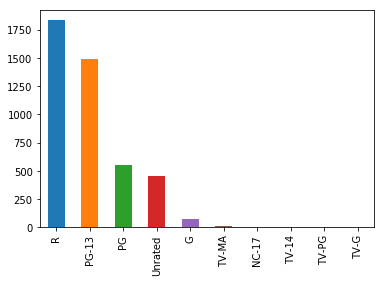

In [54]:
movie.Rating.value_counts().plot.bar();

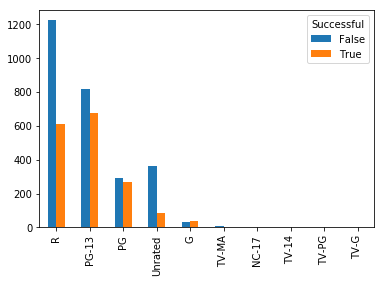

In [55]:
ctab = pd.crosstab(index=movie.Rating, columns=movie.Successful)
ctab.loc[movie.Rating.value_counts().index].plot.bar();

We got a brief introdution of the rating systems. We mainly referred two rating systems including the Motion Picture Association of America (MPAA)- a film content rating system in the US and the TV parental guidelines- a television content rating system in the US.

The MPAA film ratings are as follows[From Wikipedia]:	
G: General Audiences(All ages admitted. 
PG: Parental Guidance Suggested
PG-13: Parents Strongly Cautioned
R: Restricted
NC-17: Adults Only
TV-G:This program is suitable for all ages。
TV-PG: This program contains material that parents may find unsuitable for younger children.
TV-14:This program contains some material that many parents would find unsuitable for children under 14 years of age
TV-MA:This program is specifically designed to be viewed by adults


As we expected, we found that the vast majority of the movies used the MPAA system and only sparse ones used the TVPG. From the first plot, we found a fact that the number of the movies increased with the parental guidelines getting stricter. As we can see, the largest number of movies belonged to the R rating. While the movies could be viewed by all ages accounted for the least part of all the movies.

But, the second plot told us one interesting thing that all ages addmitted movies are most likely to be suceessful, even though the very least figure of movies were this type. Looking at the plot more carefully, unlike the first plot, we could tell the reverse disciplines that the rate of the movies being successful was getting lower with the parental guidelines getting stricter.

## 3.2 Release Date
* we wanted to get some views from the released dates of all the movies. Because, according to the common sense, we might think that the releasing of the movie would show some seasonal features. The amount of movies releasd may fluctuate yearly, you know, against the macroeconomics cycles.

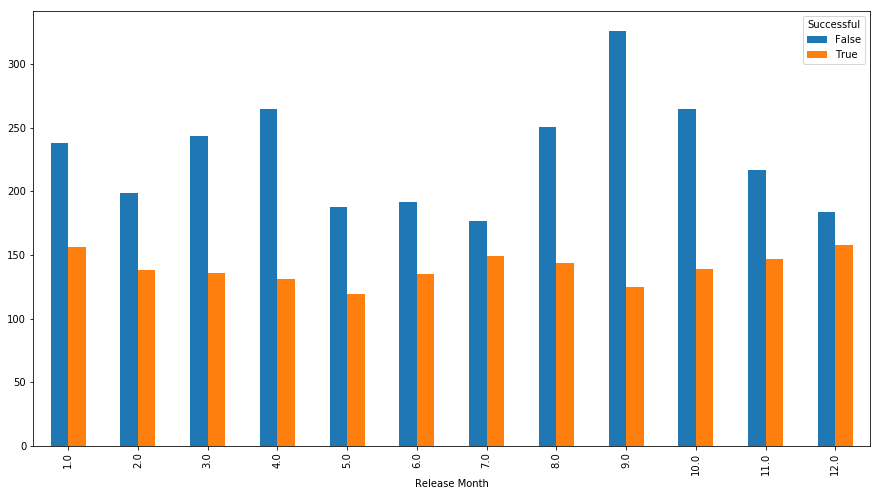

In [56]:
ctab = pd.crosstab(index=movie.Release_Date.dt.month, columns=movie.Successful)
ctab.plot.bar(figsize=figsize)
plt.xlabel('Release Month')
plt.show()

From the monthly graph, we could see that September seemed to be the most favrioute month for film producers to release their movies. The second month would be the August. But the success rate in these two months disapointed film producers. Because the larger number of the movies in September and August were failed. Of course, this rule applyed to every month.
Even though, we still found an inspired rule that films released in May, June, July, November, December and Janaury got more chance to be successful.

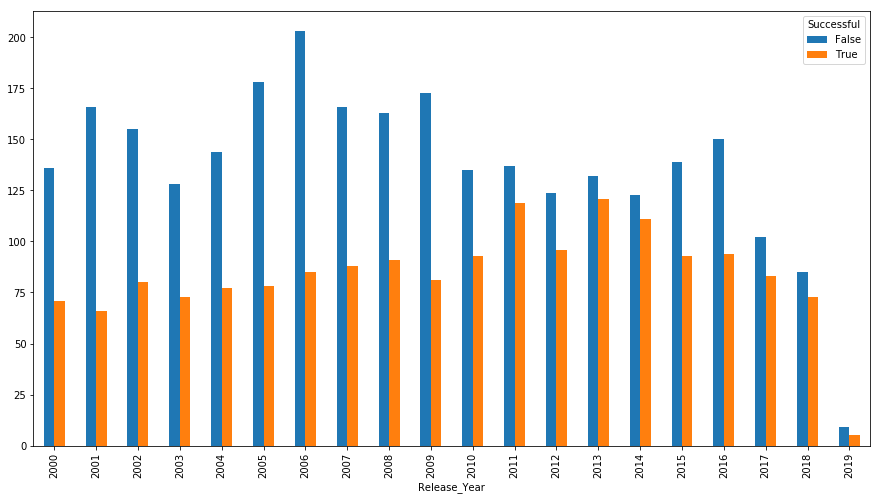

In [57]:
ctab = pd.crosstab(index=movie.Release_Year, columns=movie.Successful)
ctab.plot.bar(figsize=figsize);

According to the yearly trends graph, the tendency in film matched with the macroeconomic cycle from 2000 to 2019. It's obvious to see that the number of movies released after 2010 was decreasing. 

## 3.3 Length
* What is the optimum length of a movie? In this part, we could tell you the answer.

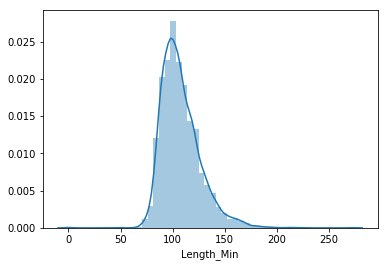

In [58]:
sns.distplot(movie.Length_Min);

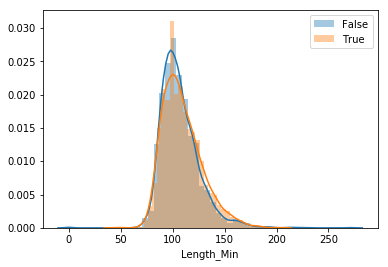

In [59]:
sns.distplot(movie.Length_Min[~movie.Successful]);
sns.distplot(movie.Length_Min[movie.Successful]);
plt.legend(['False', 'True']);

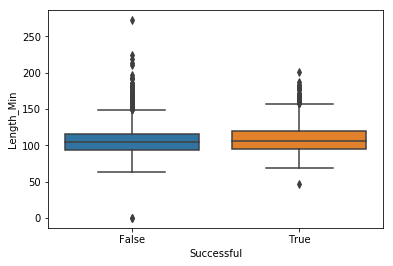

In [60]:
sns.boxplot(x='Successful', y='Length_Min', data=movie);

From the first plot and second plot we found that the length of the moviees and the success rate of the moviees seemed to be normally distributed. The third plot supported this finding. From these three plots, we got to know that the length of almost all the movies varied from 70 minutes to 150 minutes and the majority of the movies and the largest number of successful movies both were around 100 minutes.

## 3.4 Budget
* How could we define if a movie is successful or not? In this report, we used the return on investment ("ROI") as a standard to evaluate a movie. Specifically, we considered a movie with a ROI greater than or equal 1 as successful. One thing we needed to clarify was that we got each ROI just by dividing the revenue by the budget, because we wanted to simplify the process of the evalution. From this view, budget did matter. So, we would have a look at budgets.

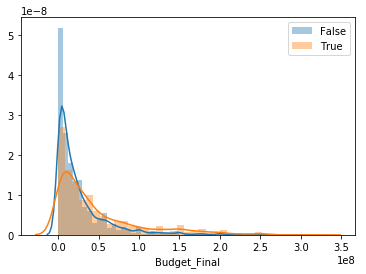

In [61]:
sns.distplot(movie.Budget_Final[~movie.Successful]);
sns.distplot(movie.Budget_Final[movie.Successful]);
plt.legend(['False', 'True']);

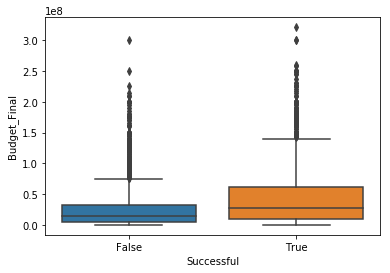

In [62]:
sns.boxplot(x='Successful', y='Budget_Final', data=movie);

From the graph and the box plot above, most of the moives had budgets lower than USD 50 millions. And we found one thing that might not supries you was that the movie with the bigger budges tended to be more successful.  

## 3.5 Genre
* Genre is supposed to be another important feature that may affect a movie's ROI, so want to know the distribution of successful and unsuccessful movies among different genres.

In [63]:
genre_set = set()
for g in movie.Genre.apply(lambda x: x.split(', ')).tolist():
    genre_set.update(g)
genre_set.remove('Musical')
genre_set

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western'}

In [64]:
genre_cols = []
for g in genre_set:
    col = 'Genre_' + g.replace('-', '')
    genre_cols.append(col)
    movie[col] = movie.Genre.apply(lambda x: g in x)

From the figure below,we can see that the top five genres of the movies are drama, comedy, action, romance, and adventure,and the last five genres of te moviews are western, war, sport, history, and music. However, the rankings of the most successful and unsuccessful movies did not follow that way.
* From the perspective of unsuccessful,the crime, instead of the adventure, ranks fifth of genres which have the most unsuccessful movies rankings. At the same time, the animation, instead of music, ranks the fifth of the genres which have the least unsuccessful movies.<br>
* From the perspective of successful,the adventure and thriller, instead of the romance and adventure, ranks fourth and fifth, respectively, of genres which have the most successful movies rankings. 

Until now, we just g0t the information about the quantity of successful and unsuccessful movies among different genres, but it turned out that whether a genre is more successful or not is not totally coresponding to its quantity. So, we took a further step to see the proportion of successful and unsuccessful movies among in each genres.

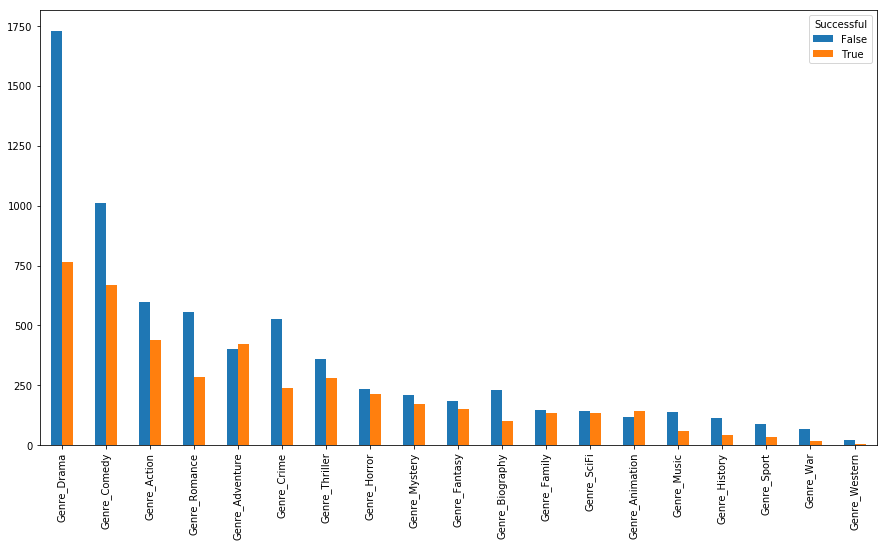

In [65]:
sorted_index = movie[genre_cols].sum().sort_values(ascending=False).index
genre_df = pd.DataFrame([movie[col].groupby(movie.Successful).sum() for col in genre_cols])
genre_df.loc[sorted_index].plot.bar(figsize=(15, 8));

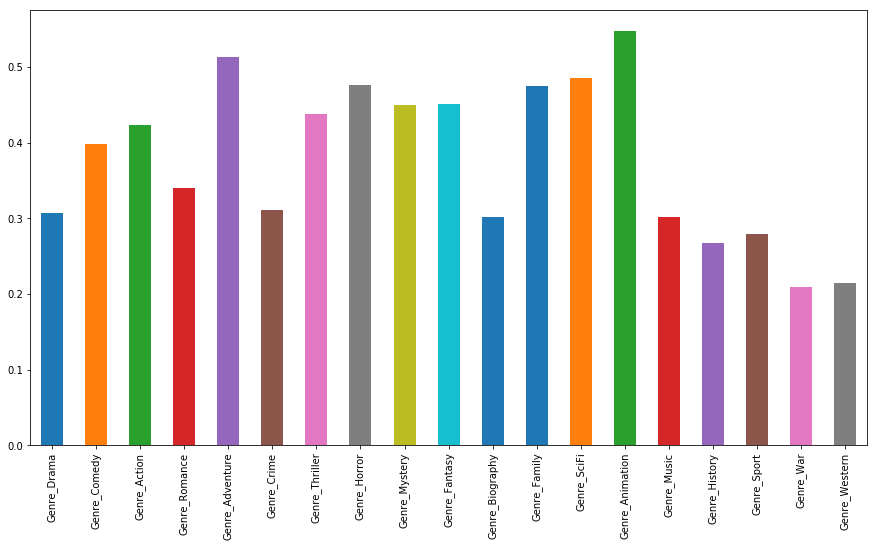

In [66]:
(genre_df[True] / (genre_df[True] + genre_df[False])).loc[sorted_index].plot.bar(figsize=(15, 8));

We plotted the proportion of successful movies in each genre below. We can see that the perecentage of successful movies in each genre did not follow the pattern of the picture above.<br> Obvisously, the animation and adventure, with more than half of chance to succeed，are the top two categories that most proporbably to succeed. Follow them, are the genres of scifi, horror, family, fantasy, mystery, thriller, and action, whose proportions of successful movies are more than 40 percent. One point we noticed is the adventure is the only genre that exists in both lists of the top 5 genres that have the most successful movies and the top 5 genres that have the higgest proportion of successful movies.<br>Besides, the top five genres that have the smallest quantities of movies also have the lowest proportion of successful movies. Regarding this, maybe the investors should consider invest these genres of movies as few as possible.
Another intersting findings is that the drama, which has both the most successful and unsuccessful movies, have a proportion that just exceeds 30 percent, a relatively low rate. This maybe because that one movie may have mutiple tags of genres and drama often appears with other genres simultaneously. That means the intersect effect of drama and other genres may lead a movie to unsucceed, not that the drama itself.

In [67]:
df['Movie_ID'] = df.Review_URL.apply(lambda x: x.split('/')[4])
crew = []
for i, r in df.iterrows():
    movie_id = r.Movie_ID
    for director in r.Director.split('/'):
        if 'more credit' not in director:
            crew.append([movie_id, director, 'director'])
    for writer in r.Writer.split('/'):
        if 'more credit' not in writer:
            crew.append([movie_id, writer, 'writer'])
    for star in r.Star.split('/'):
        if not star.endswith('crew'):
            crew.append([movie_id, star, 'star'])
person = pd.DataFrame(crew, columns=['Movie_ID', 'Person', 'Role'])

In [68]:
df

,Title,Subtext,Rating,Length,Genre,Release_Date,Director,Writer,Star,Cast,Box_Office,Review_URL,Release_Year,Budget,Box_Office_USA,Box_Office_World,Movie_ID
0,Star Wars: Episode VII - The Force Awakens (2015),None,PG-13,2h 16min,"Action, Adventure, Fantasy",18 December 2015 (USA),J.J. Abrams,Lawrence Kasdan/J.J. Abrams/2 more credits,Daisy Ridley/John Boyega/Oscar Isaac/See full ...,nm0000148 ... Harrison Ford ... Han Solo|nm000...,"Budget:$245,000,000 (estimated)|Opening Weeken...",https://www.imdb.com/title/tt2488496/reviews?r...,2015,"$245,000,000 (estimated)","$936,662,225","$2,068,223,624",tt2488496
1,Avatar (2009),None,PG-13,2h 42min,"Action, Adventure, Fantasy",18 December 2009 (USA),James Cameron,James Cameron,Sam Worthington/Zoe Saldana/Sigourney Weaver/S...,nm0941777 ... Sam Worthington ... Jake Sully|n...,"Budget:$237,000,000 (estimated)|Opening Weeken...",https://www.imdb.com/title/tt0499549/reviews?r...,2009,"$237,000,000 (estimated)","$760,507,625","$2,787,965,087, 13 February 2015",tt0499549
2,Black Panther (2018),None,PG-13,2h 14min,"Action, Adventure, Sci-Fi",16 February 2018 (USA),Ryan Coogler,Ryan Coogler/Joe Robert Cole/2 more credits,Chadwick Boseman/Michael B. Jordan/Lupita Nyon...,nm1569276 ... Chadwick Boseman ... T'Challa / ...,"Budget:$200,000,000 (estimated)|Opening Weeken...",https://www.imdb.com/title/tt1825683/reviews?r...,2018,"$200,000,000 (estimated)","$700,059,566","$1,347,071,259",tt1825683
3,Avengers: Infinity War (2018),None,PG-13,2h 29min,"Action, Adventure, Fantasy",27 April 2018 (USA),Anthony Russo/Joe Russo,Christopher Markus/Stephen McFeely/14 more cre...,Robert Downey Jr./Chris Hemsworth/Mark Ruffalo...,nm0000375 ... Robert Downey Jr. ... Tony Stark...,"Budget:$321,000,000 (estimated)|Opening Weeken...",https://www.imdb.com/title/tt4154756/reviews?r...,2018,"$321,000,000 (estimated)","$678,815,482","$2,048,709,917",tt4154756
4,Titanic (1997),None,PG-13,3h 14min,"Drama, Romance",19 December 1997 (USA),James Cameron,James Cameron,Leonardo DiCaprio/Kate Winslet/Billy Zane/See ...,nm0000138 ... Leonardo DiCaprio ... Jack Dawso...,"Budget:$200,000,000 (estimated)|Opening Weeken...",https://www.imdb.com/title/tt0120338/reviews?r...,1997,"$200,000,000 (estimated)","$659,325,379, 10 December 2017","$2,186,772,302, 11 August 2015",tt0120338
5,Jurassic World (2015),None,PG-13,2h 4min,"Action, Adventure, Sci-Fi",12 June 2015 (USA),Colin Trevorrow,Rick Jaffa/Amanda Silver/5 more credits,Chris Pratt/Bryce Dallas Howard/Ty Simpkins/Se...,nm0695435 ... Chris Pratt ... Owen|nm0397171 ....,"Budget:$150,000,000 (estimated)|Opening Weeken...",https://www.imdb.com/title/tt0369610/reviews?r...,2015,"$150,000,000 (estimated)","$652,270,625","$1,671,713,208",tt0369610
6,The Avengers (2012),None,PG-13,2h 23min,"Action, Adventure, Sci-Fi",4 May 2012 (USA),Joss Whedon,Joss Whedon/Zak Penn/1 more credit,Robert Downey Jr./Chris Evans/Scarlett Johanss...,nm0000375 ... Robert Downey Jr. ... Tony Stark...,"Budget:$220,000,000 (estimated)|Opening Weeken...",https://www.imdb.com/title/tt0848228/reviews?r...,2012,"$220,000,000 (estimated)","$623,357,910","$1,519,557,910",tt0848228
7,Star Wars: Episode VIII - The Last Jedi (2017),None,PG-13,2h 32min,"Action, Adventure, Fantasy",15 December 2017 (USA),Rian Johnson,Rian Johnson/George Lucas,Daisy Ridley/John Boyega/Mark Hamill/See full ...,nm0000434 ... Mark Hamill ... Luke Skywalker /...,"Opening Weekend USA: $220,009,584, 17 December...",https://www.imdb.com/title/tt2527336/reviews?r...,2017,None,"$620,181,382","$1,332,539,889",tt2527336
8,Incredibles 2 (2018),None,PG,1h 58min,"Animation, Action, Adventure",15 June 2018 (USA),Brad Bird,Brad Bird,Craig T. Nelson/Holly Hunter/Sarah Vowell/See ...,nm0005266 ... Craig T. Nelson ... Bob Parr / M...,"Budget:$200,000,000 (estimated)|Opening Weeken...",https://www.imdb.com/title/tt3606756/reviews?r...,2018,"$200,000,000 (estimated)","$608,581,744","$1,242,770,554",tt3606756
9,The Dark Knight (2008),None,PG-13,2h 32min,"Action,

## 3.6 Review
* Before a movie is released to the public, a small portion of audiences, such as the professional movie critic，may have the access to that movie, and after that, they will write their reviews on IMDB. After the moview is released to public, a lot of audiences would like to take a look at the reviews on IMDB and then decide whether to watch that moive or not. So, in our intuition, the popularity of a movie often corresponds to the reviews of that movie. Thus, we determined to identify the relationships between the number of reviews and the success of movies. 

In [69]:
movie = movie.set_index('Movie_ID')

In [70]:
rev = rev.set_index('Movie_ID')

In [71]:
movie = movie.sort_index()

In [72]:
movie['review_count'] = rev_count

In [73]:
review_length = rev.review_text.apply(lambda x: len(x.split()))
movie['avg_review_length'] = review_length.groupby(review_length.index).mean()

In [74]:
movie.review_count.fillna(0, inplace=True)
movie.avg_review_length.fillna(0, inplace=True)

From the histogram and boxplot of the number of reviews for each movie below, we found that both the successful and unccessful movies mainly have less than 100 reviews for each movie. More specificlly, the unsuccessful moview tend to have less reviews than successful moviews. This phenomenon not only appears at the less popular movies, which have fewer reviews, but also appears at the more popular movies.<br>
At a particular situation, where a moive has more than 500 reviews, the movie is certain to be successful. This information maybe very helpful to the investors, because they can spend more money marketing the movie to get more reviews before the movie is released to the public, and thus making the movie succeed.

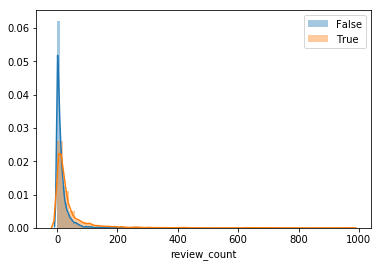

In [75]:
sns.distplot(movie.review_count[~movie.Successful]);
sns.distplot(movie.review_count[movie.Successful]);
plt.legend(['False', 'True']);

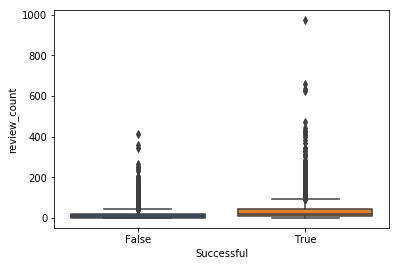

In [76]:
sns.boxplot(x='Successful', y='review_count', data=movie);

From the two figures of review_length, we found three things:
* The uncessful movies tend to not have any review than the successful ones. And for those movies which have reviews
* The successful movies have a slightly higher proportion than the unsuccessful movies that have reviews.
* The successful movies have a slightly longer average length of reviews than the unsuccessful movies

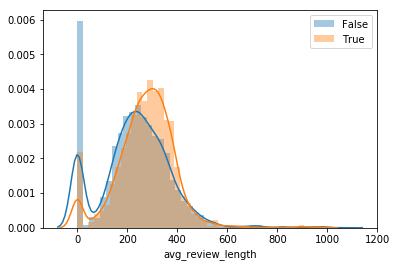

In [77]:
sns.distplot(movie.avg_review_length[~movie.Successful]);
sns.distplot(movie.avg_review_length[movie.Successful]);
plt.legend(['False', 'True']);

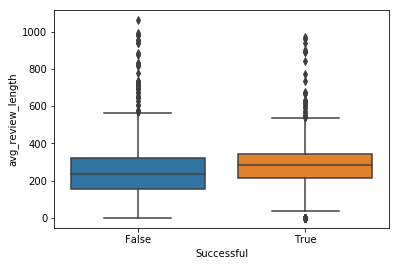

In [78]:
sns.boxplot(x='Successful', y='avg_review_length', data=movie);

The histograms of boxplots of average rating for successful and unsuccessful movies looks pretty same, the only difference is that the ratings of successful movies are a little more close to each other than the unsuccessful movies.

In [79]:
rev.rating = pd.to_numeric(rev.rating.apply(lambda x: x.split('/')[0] if type(x) == str else None))

In [80]:
movie['avg_rating'] = rev.rating.groupby(rev.index).mean()

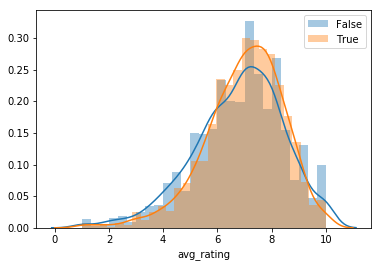

In [81]:
sns.distplot(movie.avg_rating[~movie.Successful].dropna());
sns.distplot(movie.avg_rating[movie.Successful].dropna());
plt.legend(['False', 'True']);

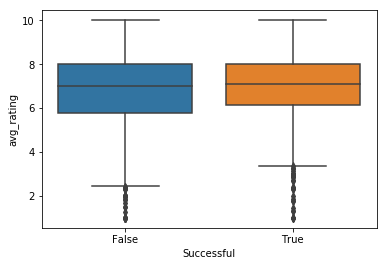

In [82]:
sns.boxplot(x='Successful', y='avg_rating', data=movie);

## 3.7 Word Cloud

In [83]:
import string
from wordcloud import WordCloud

In [84]:
cleaned_review_text = rev.review_text.apply(
    lambda x: ' '.join([word.strip(string.punctuation) for word in x.lower().split()]))

### 3.7.1 Reviews word cloud
The result does not seem to beyond our expectation. For both successful and unsuccessful movies, highlited words are pretty similar:
- Movie related words like: "character", "story", "scene"; 
- Common verbs like: "make", "think", "love", "know", "look";
- Common Nouns like: "way", "work", “one", "life";
- Common Adjectives or adverbs like: "much", "well", "though", "little";

Seems like we can't find any obvious pattern difference between reviews from successful and unsuccessful movies. It's not hard to explain: Reviews are comments around a movie, no matter it successful or not, it will use related words to describe the movie and common words to narative author's point of view.

But we can also find some difference. There's some words that only show in unsccessful movies: "film","end"; Some words' frequency are diffrent between two categories. For example: "now" is much more frequently shows in successful movies.

To obtain the true meaning behind words frequency, we will talk more in sentiment analysis in future work.


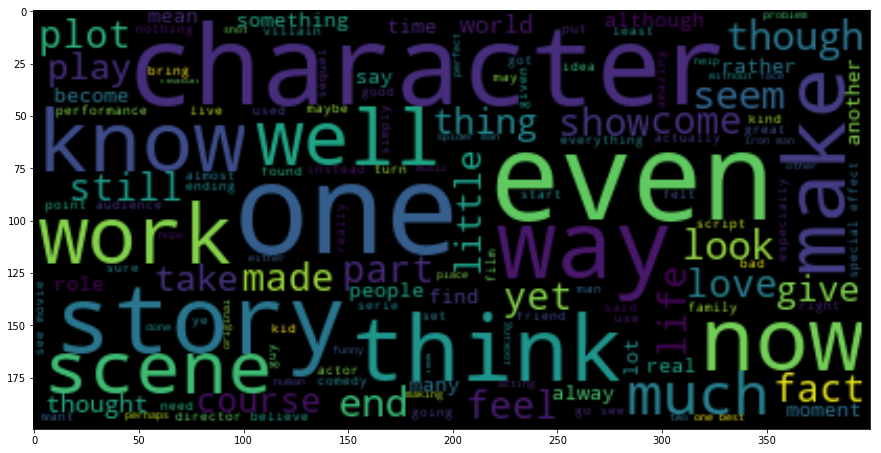

In [85]:
# Successful
text = ' '.join(cleaned_review_text[rev.Successful])
word_cloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=figsize)
plt.imshow(word_cloud, interpolation='bilinear');

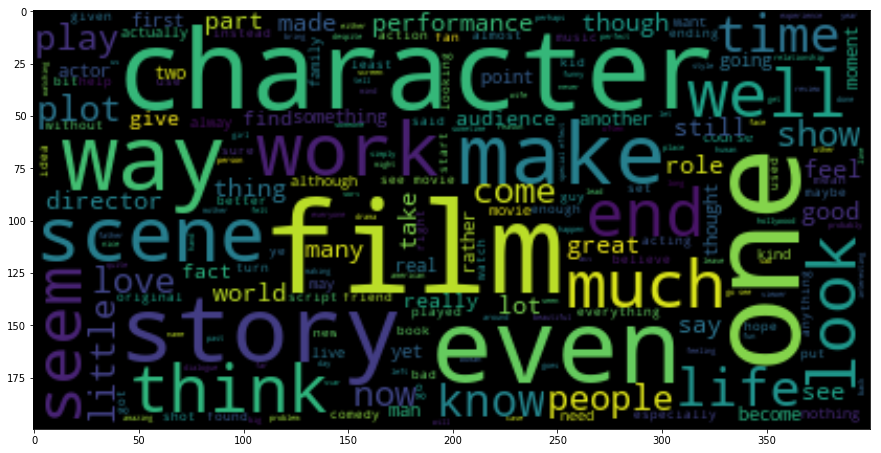

In [86]:
# not Successful
text = ' '.join(cleaned_review_text[~rev.Successful])
word_cloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=figsize)
plt.imshow(word_cloud, interpolation='bilinear');

### 3.7.2 Directors' word cloud

A director is a person who expresses his thoughts with plots and actors. The quality of a movie depends to a large extent on the ability of director; the style of a movie often reflects the director's artistic style and character, and more reflects the director's thought of the world. In this part, we count each director's successful and unsuccessful movies and use word cloud to show the result:

For successful movies, we can see some big names: Steven Spielberg, Christopher Nolan, Clint Eastwood, Michael Bay, Steven Soderbergh...

Spielberg focus on science fiction and adventure movies such as *Ready Player One*, *A.I.*, *Back to Future*, he is seen as a classic example of modern Hollywood blockbuster filmmaking. 

Like Spielberg, Nolan also focus on science fiction movies such as *Interception*, *Interstella*. And some superhero movies like *The Dark Knight*.

From the audience's point of view, these director's films are very attractive no matter from the perspective of genre, story or production.

For unsuccessful movies, some name are also well known: Woody Allen, Jean, Ridley Scott. What's interesting is some directors such as Steven Soderbergh and Clint Eastwood both show in successful and unsccessful movies.

In our opinion, we can't consider a director is not good enough by this word cloud, some genre like Art films are likely to have less box office revenue.

We will analysis more by combining the feature of genre in the future work.

In [87]:
m_person = movie[['Successful']].merge(person, left_index=True, right_on='Movie_ID')
m_person.Person = m_person.Person.apply(lambda x: x.replace(' ', '_'))

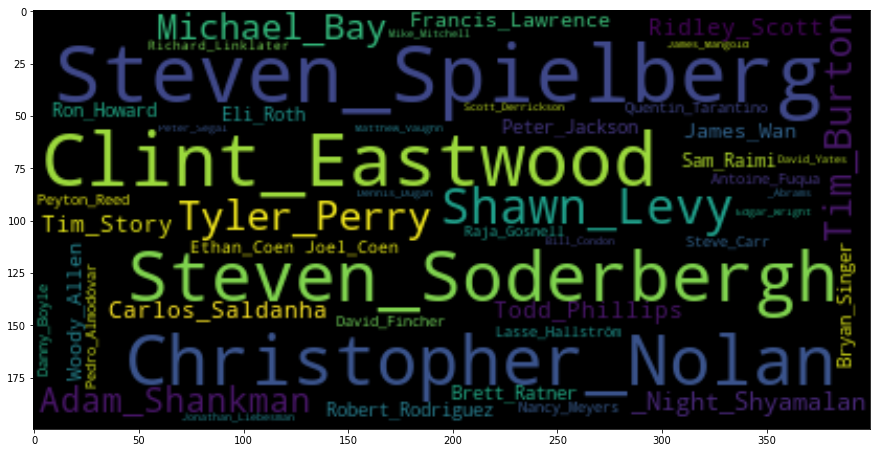

In [88]:
# successful directors
text = ' '.join(m_person.Person[m_person.Role == 'director'][m_person.Successful])
word_cloud = WordCloud().generate(text)
plt.figure(figsize=figsize)
plt.imshow(word_cloud, interpolation='bilinear');

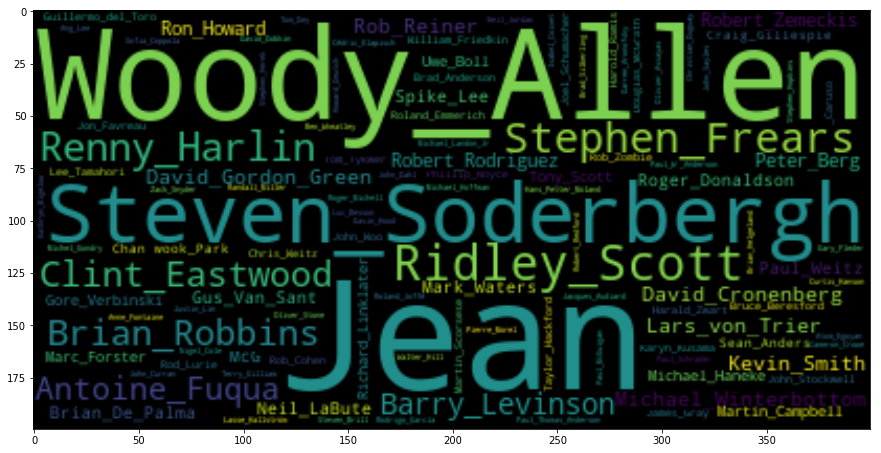

In [89]:
# unsuccessful directors
text = ' '.join(m_person.Person[m_person.Role == 'director'][~m_person.Successful])
word_cloud = WordCloud().generate(text)
plt.figure(figsize=figsize)
plt.imshow(word_cloud, interpolation='bilinear');

### 3.7.3 Writers' word cloud
Like directors, The influence of the script on the film is also greatly limited by the genre. Because some director will both direct and wright for his film. So Woody Allen, Jean show in the unsuccessful movies again. So, we consider the writers' influence to a movie may have some similarity with directors.

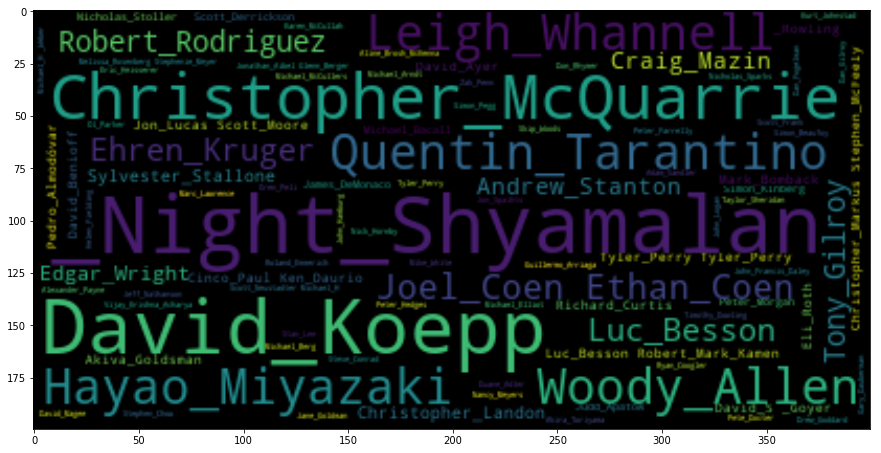

In [90]:
# successful writers
text = ' '.join(m_person.Person[m_person.Role == 'writer'][m_person.Successful])
word_cloud = WordCloud().generate(text)
plt.figure(figsize=figsize)
plt.imshow(word_cloud, interpolation='bilinear');

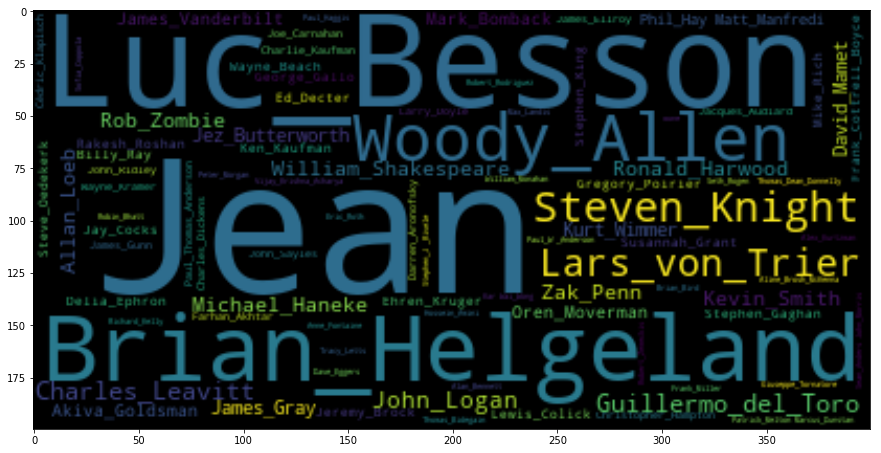

In [91]:
# unsuccessful writers
text = ' '.join(m_person.Person[m_person.Role == 'writer'][~m_person.Successful])
word_cloud = WordCloud().generate(text)
plt.figure(figsize=figsize)
plt.imshow(word_cloud, interpolation='bilinear');

### 3.7.4 Actors' word cloud
From our point of view, actors can bring a more direct feeling to the audience, and can also have a more direct impact on the success of the film.

What interest us is all the actors showed in both successful and un successful movies are very famous ones. Dwayne Johnson's advanture films always have a large number of fans. George Clooney won the praise of both male and female audiences for his outstanding appearance and superb acting. In the other hand, Actor and actress like Nicholas Cage, Robert De Niro, Nicole Kidman are also great and outstanding. We will find the reason why these great actor or actress didn't made their movie successful in future work.

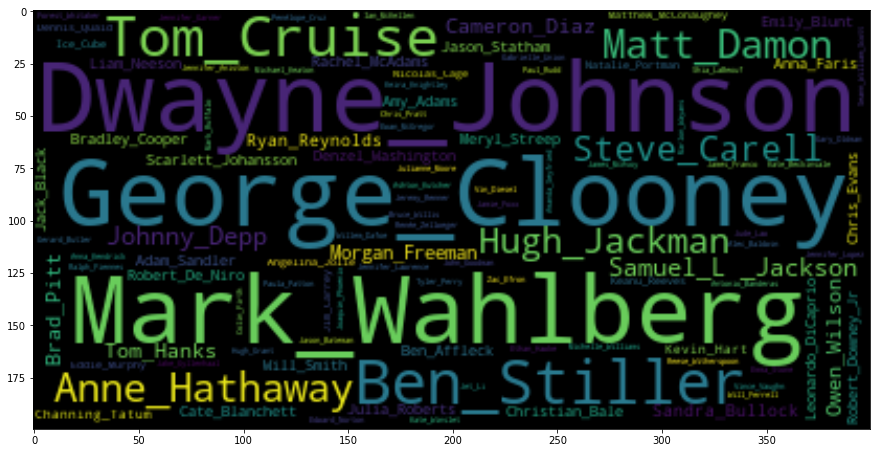

In [92]:
# successful actors
text = ' '.join(m_person.Person[m_person.Role == 'star'][m_person.Successful])
word_cloud = WordCloud().generate(text)
plt.figure(figsize=figsize)
plt.imshow(word_cloud, interpolation='bilinear');

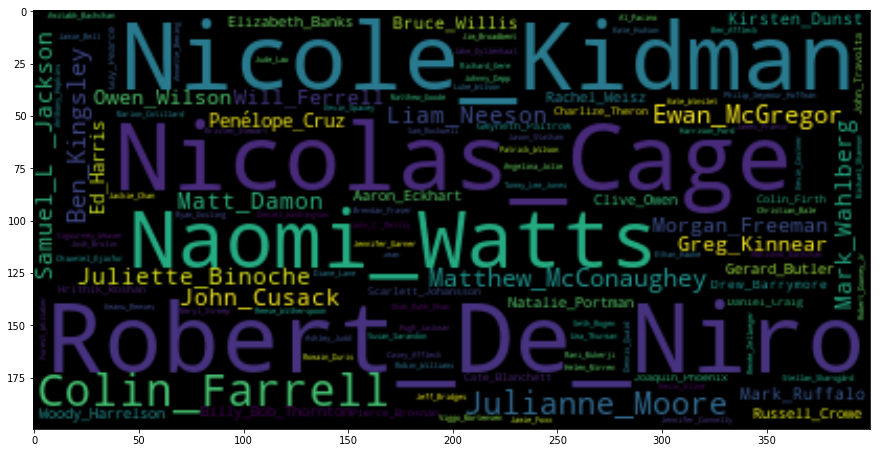

In [93]:
# unsuccessful actors
text = ' '.join(m_person.Person[m_person.Role == 'star'][~m_person.Successful])
word_cloud = WordCloud().generate(text)
plt.figure(figsize=figsize)
plt.imshow(word_cloud, interpolation='bilinear');

# 4. Project Plan


* In the EDA part, we found that director and star may have a huge impact on the performance of movie. In the next step, we want to quantify the influence of director and star. For example, Allen is the director of movie A. In order to calculate the influence of Allen, we wil calculte the mean revenue of total movie that Allen had directed before the release of movie A. We will use the same method to measure the influence of star.

* Name Entity Recognition: We want to use name entity recognition to extract person names in review text. Hopefully, we can classify our review and identify the content of the review. For example, some reviews may talk about a movie star, while others may mainly talk about the characters. In this way we might explain whether the movie attracts people by its cast or by the story.  

* Model: 
    First, we will use all the category feature to build a baseline. In this step, we’ll use multiple classification models: LDA, Logistic regression, NaiveBayes, KNN, SVM, Decition tree, Neural Network, and some ensemble method. 
    Next, we'll add some features we mentioned before such as directors, actors, genre, and text feature(extracted in Name Entity Recognition steps)to modify the model.
    Then get cadidates of feature set using several methods (PCA, stepward regression and so on).Use the cadidates in the best model and choose the final feature set.

